In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from math import sqrt
from scipy.stats import pearsonr

In [2]:
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.filters.morningstar import IsPrimaryShare

Why You Should Hedge Beta and Sector Exposures (Part I)

In [3]:
def make_pipeline():
    
    #Factor returns
    market_cap = Fundamentals.market_cap.latest > 1e8 # Market_Cap over 100mil
    market_cap0 = Fundamentals.market_cap.latest
    is_liquid = AverageDollarVolume(window_length=5).percentile_between(99.5, 100)
    prices = USEquityPricing.close.latest
   
    universe = (QTradableStocksUS()
                & is_liquid
                & market_cap)
    

    pipe = Pipeline(
        columns={
            'close_prices': prices,
            'market_cap': market_cap0,

        },
        screen=universe
    )
    
    return pipe
data = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2017-01-01')

In [4]:
# Drop missing data
data.dropna(inplace=True)
data.head()

close_prices    market_cap
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])          110.43  6.473610e+11
                          Equity(700 [BAC])           17.89  1.881393e+11
                          Equity(1335 [C])            54.12  1.639256e+11
                          Equity(1406 [CELG])        111.87  8.934305e+10
                          Equity(3149 [GE])           25.27  2.537662e+11

In [5]:
asset_list = data.index.levels[1]
prices = get_pricing(asset_list, start_date='2015-01-01', end_date='2017-01-01', fields='price')
prices.columns = map(lambda x: x.symbol, prices.columns)
num_stocks = len(asset_list)
print 'Number of stocks:', num_stocks 
prices.head()

Number of stocks: 151


,AAPL,ABT,TAP,AET,AIG,ALTR,AMAT,AMD,TWX,AMGN,...,KRFT,AMBA,ABBV,COTY,FEYE,TWTR,AAL,GPRO,SYF,PYPL
2015-01-02 00:00:00+00:00,105.130,42.898,71.087,87.174,54.125,36.496,24.033,2.695,81.679,152.620,...,62.254,50.96,61.420,19.879,31.030,36.55,52.859,66.865,29.189,NaN
2015-01-05 00:00:00+00:00,102.196,42.917,70.683,86.016,53.064,36.142,23.281,2.660,80.102,150.910,...,61.469,50.67,60.311,19.840,32.000,36.38,52.830,66.020,29.000,NaN
2015-01-06 00:00:00+00:00,102.177,42.410,70.327,86.124,52.282,35.561,22.404,2.620,79.141,146.039,...,61.479,52.80,59.947,19.636,29.760,38.76,52.006,64.800,28.564,NaN
2015-01-07 00:00:00+00:00,103.639,42.764,72.569,87.822,52.552,35.591,22.616,2.590,79.977,151.178,...,62.791,60.00,62.408,19.762,30.885,37.28,51.967,62.380,28.931,NaN
2015-01-08 00:00:00+00:00,107.602,43.633,74.812,90.747,52.321,36.417,23.329,2.610,82.208,150.528,...,63.606,59.85,63.042,19.933,33.080,39.11,52.614,60.040,29.674,NaN


In [6]:
from sklearn.covariance import LedoitWolf

#rets = prices.pct_change().fillna(0) # Calculate returns
rets = prices.pct_change()[1:] # Calculate returns
rets0 = rets.fillna(0)
lw_cov = LedoitWolf().fit(rets0).covariance_ # Calculate Ledoit-Wolf Estimator
symbols = rets0.index 

In [7]:
def extract_corr_from_cov(cov_matrix):
    # Linear algebra result:
    # https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

In [8]:
tickers = prices.columns
corr = extract_corr_from_cov(lw_cov)

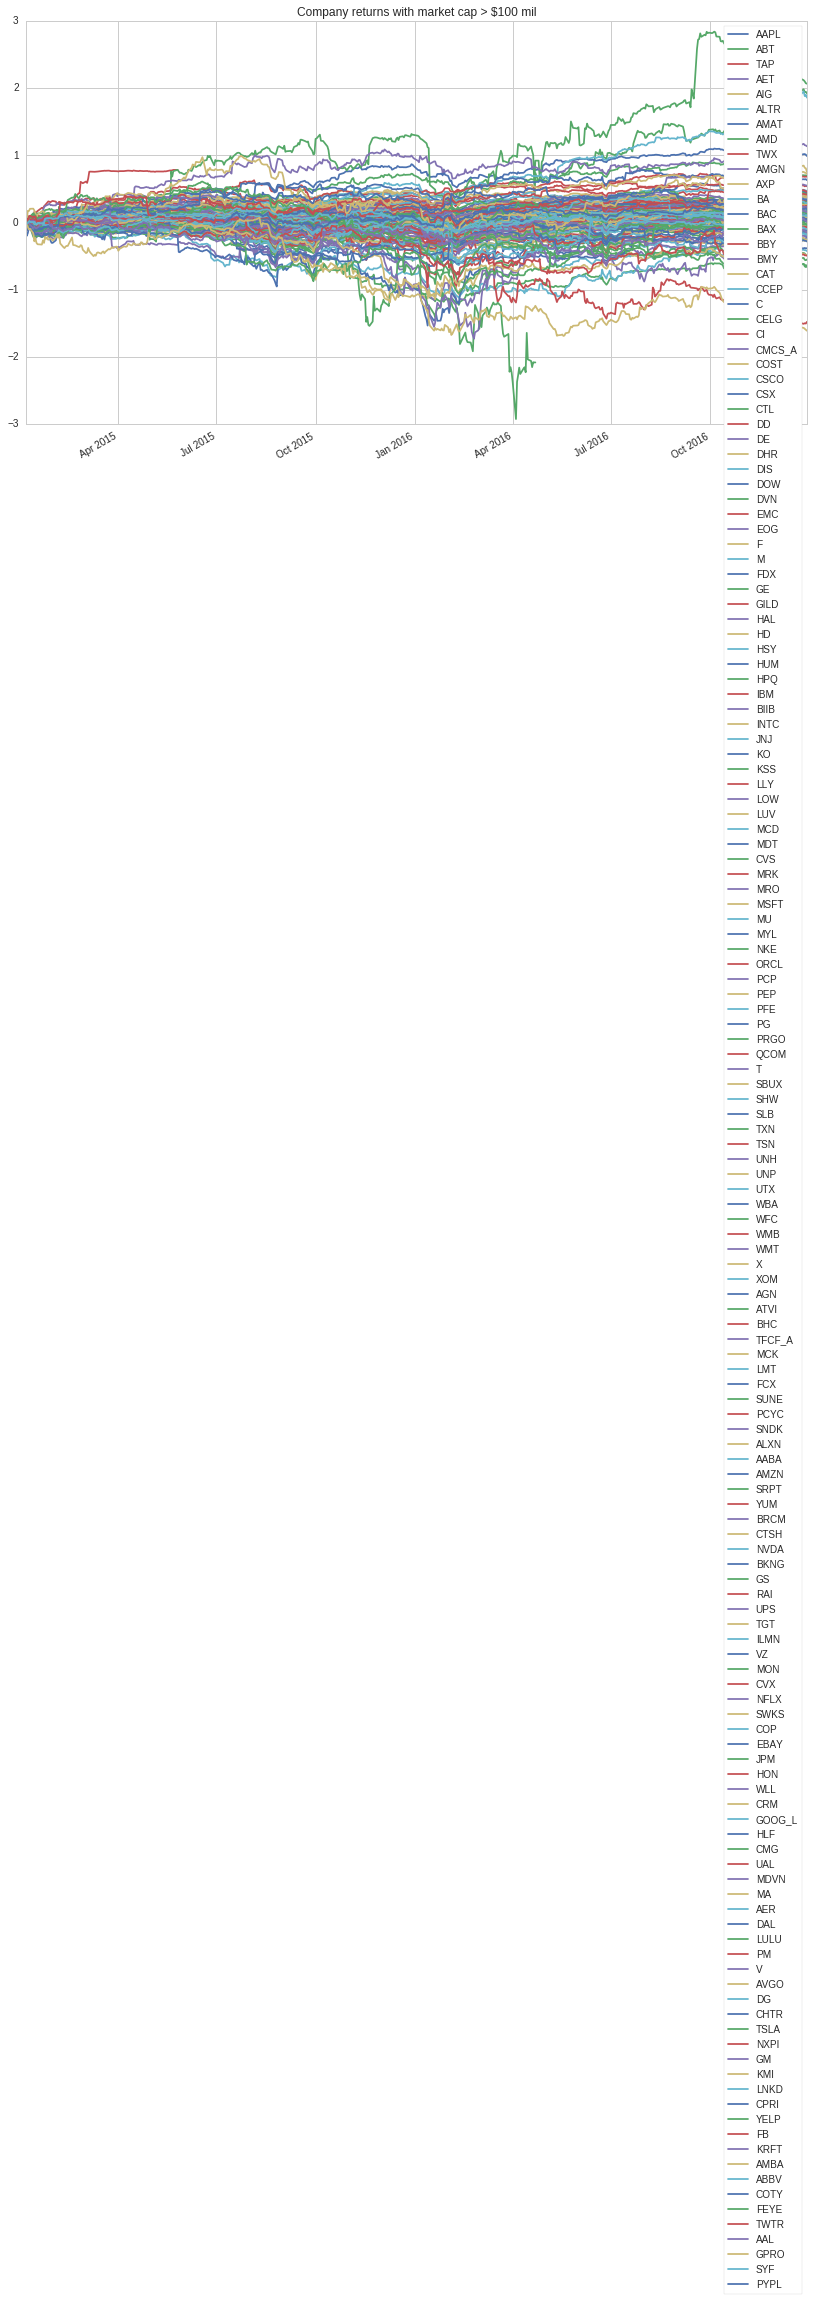

In [9]:
# Plot prices
rets.cumsum().plot()
plt.legend()
plt.title('Company returns with market cap > $100 mil');

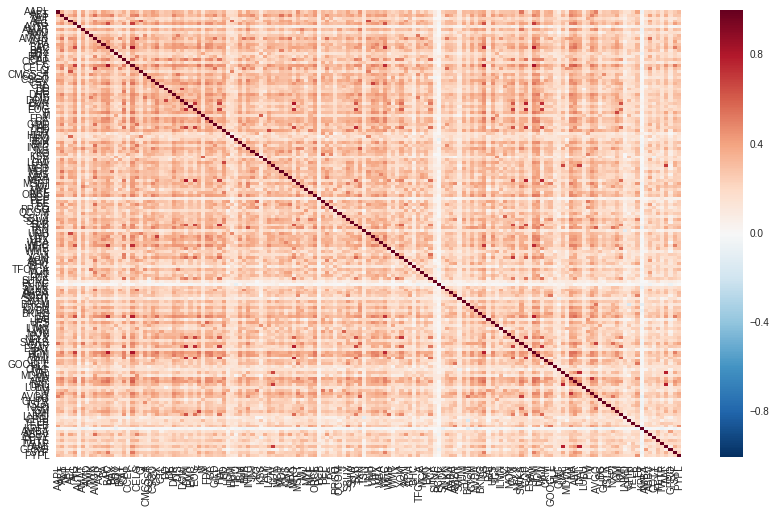

In [10]:
# Plot covariance as a heat map
sns.heatmap(corr, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers);

In [11]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print 'Average pairwise correlation: %.4f' % average_corr

Average pairwise correlation: 0.2428


estimating-covariance-matrices

In [12]:
dates = rets0.resample('M').first().index

In [13]:
from sklearn import covariance
returns = rets0

In [14]:
sample_covs = []
lw_covs = []

for i in range(1, len(dates)):
    sample_cov = returns[dates[i-1]:dates[i]].cov().values
    sample_covs.append(sample_cov)
    
    lw_cov = covariance.ledoit_wolf(returns[dates[i-1]:dates[i]])[0]
    lw_covs.append(lw_cov)      

In [15]:
lw_diffs = []
for pair in zip(lw_covs[:-1], lw_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    lw_diffs.append(diff)

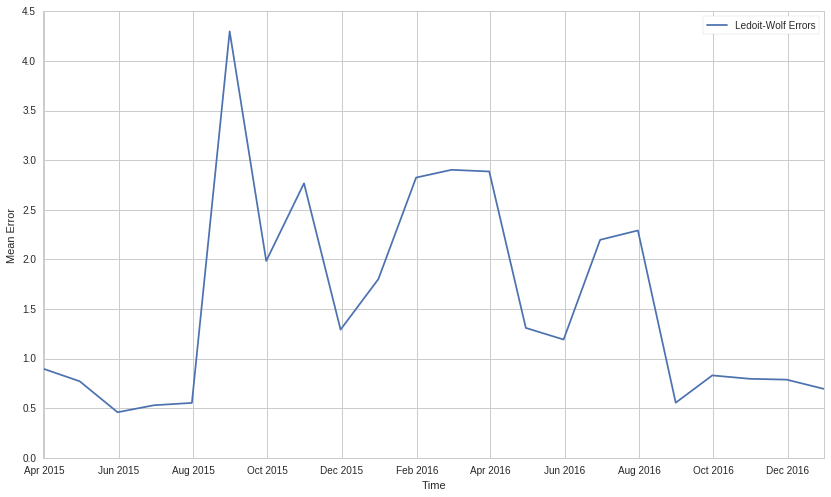

In [16]:
plt.plot(dates[2:], lw_diffs)
plt.xlabel('Time')
plt.ylabel('Mean Error')
plt.legend(['Ledoit-Wolf Errors']);

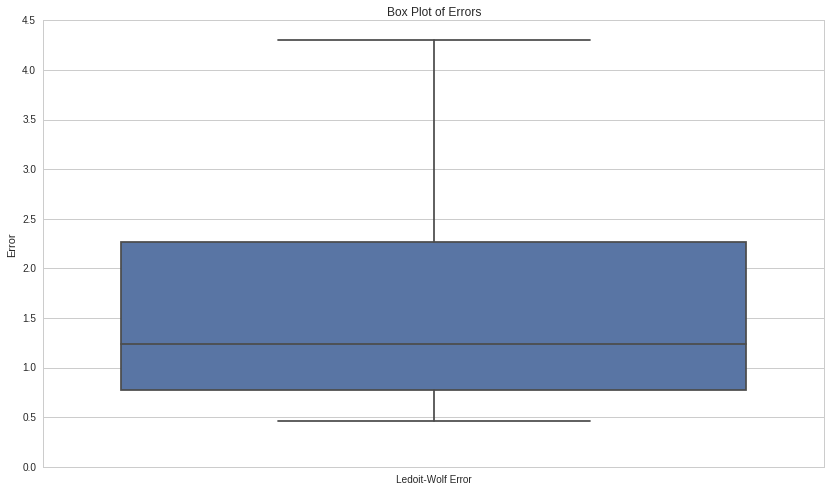

In [17]:
sns.boxplot(
    data = pd.DataFrame({
        'Ledoit-Wolf Error': lw_diffs
    })
)
plt.title('Box Plot of Errors')
plt.ylabel('Error');


Universe Selection

In [18]:
market_cap = Fundamentals.market_cap.latest > 1e8 # Market_Cap over 100mil
is_liquid = AverageDollarVolume(window_length=5).percentile_between(99.5, 100)
prices = USEquityPricing.close.latest
   
universe = (QTradableStocksUS()
            & is_liquid
            & market_cap)
    

In [19]:
from quantopian.pipeline.classifiers.fundamentals import Sector  

# Rename our universe to Lectures500
Liquid_120 = universe

SECTOR_CODE_NAMES = {
    Sector.BASIC_MATERIALS: 'Basic Materials',
    Sector.CONSUMER_CYCLICAL: 'Consumer Cyclical',
    Sector.FINANCIAL_SERVICES: 'Financial Services',
    Sector.REAL_ESTATE: 'Real Estate',
    Sector.CONSUMER_DEFENSIVE: 'Consumer Defensive',
    Sector.HEALTHCARE: 'Healthcare',
    Sector.UTILITIES: 'Utilities',
    Sector.COMMUNICATION_SERVICES: 'Communication Services',
    Sector.ENERGY: 'Energy',
    Sector.INDUSTRIALS: 'Industrials',
    Sector.TECHNOLOGY: 'Technology',
    -1 : 'Misc'
}

def get_sector_codes(day, universe):
    pipe = Pipeline(columns={'Sector': Sector()}, screen=universe)
    # Drop the datetime level of the index, since we only have one day of data 
    return run_pipeline(pipe, day, day).reset_index(level=0, drop=True)


def calculate_sector_counts(sectors):
    counts = (sectors.groupby('Sector').size())

    # Replace numeric sector codes with human-friendly names
    counts.index = counts.index.map(lambda code: SECTOR_CODE_NAMES[code])
    return counts

Liquid_120_sectors = get_sector_codes('2017-01-01', Liquid_120)
Liquid_120_counts = calculate_sector_counts(Liquid_120_sectors)

In [20]:
def plot_sector_counts(sector_counts):
    
    bar = plt.subplot2grid((5,5), (0,0), rowspan=2, colspan=5)
    pie = plt.subplot2grid((5,5), (2,0), rowspan=3, colspan=5)
    
    # Bar chart
    sector_counts.plot(
        kind='bar',
        color='b',
        rot=30,
        ax=bar,
    )
    
    bar.set_title('Sector Exposure - Counts')
    
    # Pie chart
    sector_counts.plot(
        kind='pie', 
        colormap='Set3', 
        autopct='%.2f %%',
        fontsize=12,
        ax=pie,
    )
    pie.set_ylabel('')  # This overwrites default ylabel, which is None :(
    pie.set_title('Sector Exposure - Proportions')
    
    plt.tight_layout();

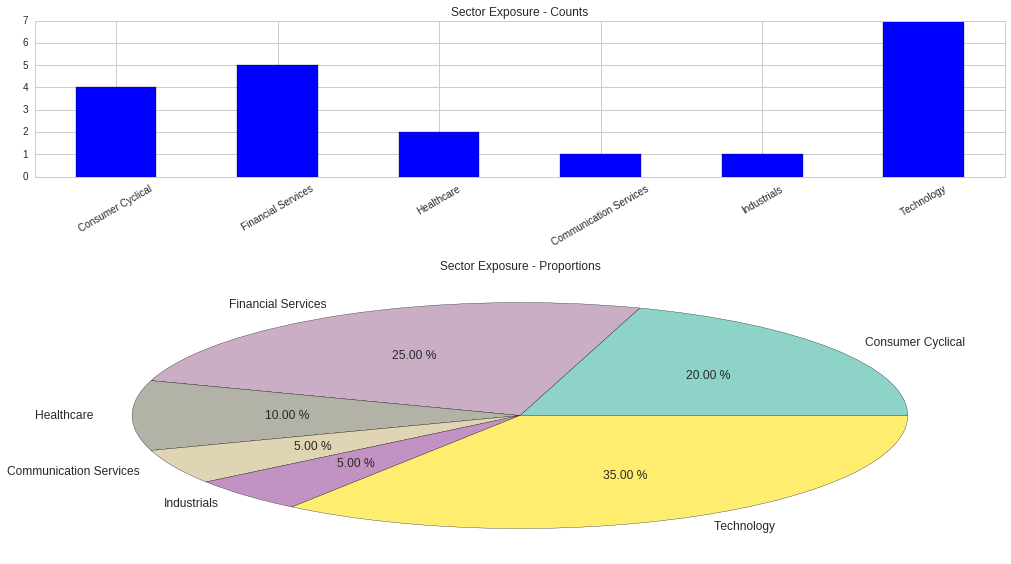

In [21]:
plot_sector_counts(Liquid_120_counts)

In [22]:
res = run_pipeline(Pipeline(columns={'Liquid_120' : Liquid_120}), '2015-01-01', '2017-01-01')
res = res.unstack().fillna(False)

def calculate_daily_turnover(unstacked):
    return (unstacked
            .diff()        # Get True/False showing where values changed from previous day.
            .iloc[1:]      # Drop first row, which is meaningless after diff().
            .astype(bool)  # diff() coerces from bool -> object :(.  Undo that.
            .groupby(axis=1, level=0)  
            .sum())        # Group by universe and count number of True values in each row.

def plot_daily_turnover(unstacked):
    
    # Calculate locations where the inclusion state of an asset changed.
    turnover = calculate_daily_turnover(unstacked)
    
    # Write the data to an axis.
    ax = turnover.plot(figsize=(14, 8))
    
    # Add style to the axis.
    ax.grid(False)
    ax.set_title('Changes per Day')
    ax.set_ylabel('Number of Added or Removed Assets')
    

def print_daily_turnover_stats(unstacked):
    turnover = calculate_daily_turnover(unstacked)
    print(turnover.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

      Liquid_120
mean    3.615079
std     2.221943
25%     2.000000
50%     3.000000
75%     5.000000
min     0.000000
max    11.000000


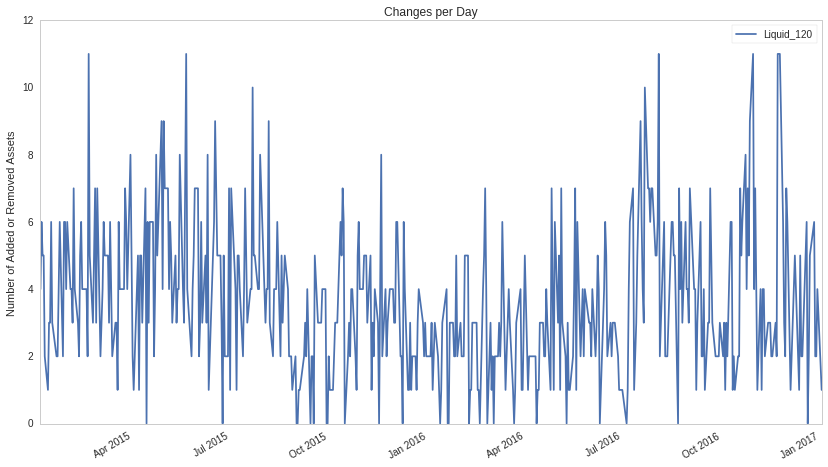

In [23]:
plot_daily_turnover(res)
print_daily_turnover_stats(res)

      Liquid_120 Smoothed
mean             0.603175
std              0.818080
25%              0.000000
50%              0.000000
75%              1.000000
min              0.000000
max              4.000000


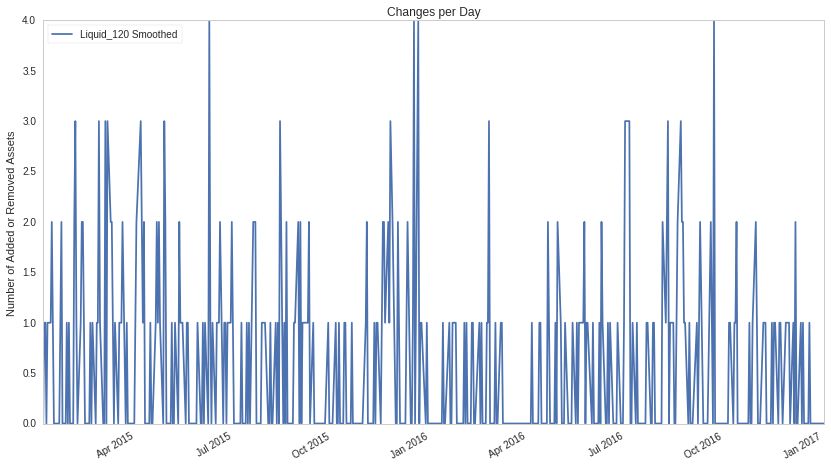

In [24]:
from quantopian.pipeline.filters import AtLeastN

Liquid_120 = AtLeastN(inputs=[Liquid_120],
                       window_length=21,
                       N=10,)

res_smoothed = run_pipeline(Pipeline(columns={'Liquid_120 Smoothed' : Liquid_120}), 
                            '2015-01-01',
                            '2017-01-01')
res_smoothed = res_smoothed.unstack().fillna(False)

plot_daily_turnover(res_smoothed)
print_daily_turnover_stats(res_smoothed)

VaR & CVaR

In [25]:
from scipy.stats import norm

In [26]:
returns = rets0
returns = returns - returns.mean(skipna=True) # de-mean the returns

factor-risk-exposure

In [27]:
import scipy.stats as stats
from quantopian.pipeline.factors import CustomFactor, Returns

In [28]:
# Here's the raw data we need, everything else is derivative.

class MarketCap(CustomFactor):
    # Here's the data we need for this factor
    inputs = [Fundamentals.shares_outstanding, USEquityPricing.close]
    # Only need the most recent values for both series
    window_length = 1
    
    def compute(self, today, assets, out, shares, close_price):
        # Shares * price/share = total price = market cap
        out[:] = shares * close_price
        
        
class BookToPrice(CustomFactor):
    # pb = price to book, we'll need to take the reciprocal later
    inputs = [Fundamentals.pb_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pb):
        out[:] = 1 / pb
        
def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    
    In particular, this function can be copy/pasted into research and run by itself.
    """
    pipe = Pipeline()

    # Add our factors to the pipeline
    market_cap = MarketCap()
    # Raw market cap and book to price data gets fed in here
    pipe.add(market_cap, "market_cap")
    book_to_price = BookToPrice()
    pipe.add(book_to_price, "book_to_price")
    
    # We also get daily returns
    returns = Returns(inputs=[USEquityPricing.close], window_length=2)
    pipe.add(returns, "returns")
    
    # We compute a daily rank of both factors, this is used in the next step,
    # which is computing portfolio membership.
    market_cap_rank = market_cap.rank()
    pipe.add(market_cap_rank, 'market_cap_rank')
    
    book_to_price_rank = book_to_price.rank()
    pipe.add(book_to_price_rank, 'book_to_price_rank')

    # Build Filters representing the top and bottom 1000 stocks by our combined ranking system.
    biggest = market_cap_rank.top(1000)
    smallest = market_cap_rank.bottom(1000)
    
    highpb = book_to_price_rank.top(1000)
    lowpb = book_to_price_rank.bottom(1000)
    
    # Don't return anything not in this set, as we don't need it.
    pipe.set_screen(biggest | smallest | highpb | lowpb)
    
    # Add the boolean flags we computed to the output data
    pipe.add(biggest, 'biggest')
    pipe.add(smallest, 'smallest')
    
    pipe.add(highpb, 'highpb')
    pipe.add(lowpb, 'lowpb')
    
    return pipe

pipe = make_pipeline()

In [29]:
start_date = '2015-01-01'
end_date = '2017-01-01'

In [30]:
results = run_pipeline(pipe, start_date, end_date)

R_biggest = results[results.biggest]['returns'].groupby(level=0).mean()
R_smallest = results[results.smallest]['returns'].groupby(level=0).mean()

R_highpb = results[results.highpb]['returns'].groupby(level=0).mean()
R_lowpb = results[results.lowpb]['returns'].groupby(level=0).mean()

SMB = R_smallest - R_biggest
HML = R_highpb - R_lowpb

In [31]:
# Get returns data for our portfolio
portfolio = rets0

R = np.mean(portfolio, axis=1)

bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# The excess returns of our active management, in this case just holding a portfolio of our one asset
active = R - bench

# Define a constant to compute intercept
constant = pd.Series(np.ones(len(active.index)), index=active.index)

df = pd.DataFrame({'R': active,
              'F1': SMB,
              'F2': HML,
              'Constant': constant})
df = df.dropna()

In [32]:
# Perform linear regression to get the coefficients in the model
b1, b2 = regression.linear_model.OLS(df['R'], df[['F1', 'F2']]).fit().params

# Print the coefficients from the linear regression
print 'Sensitivities of active returns to factors:\nSMB: %f\nHML: %f' %  (b1, b2)

Sensitivities of active returns to factors:
SMB: -0.051742
HML: 0.002586


In [33]:
F1 = df['F1']
F2 = df['F2']
cov = np.cov(F1, F2)
ar_squared = (active.std())**2
fmcar1 = (b1*(b2*cov[0,1] + b1*cov[0,0]))/ar_squared
fmcar2 = (b2*(b1*cov[0,1] + b2*cov[1,1]))/ar_squared
print 'SMB Risk Contribution:', fmcar1
print 'HML Risk Contribution:', fmcar2

SMB Risk Contribution: 0.0156693865358
HML Risk Contribution: -0.000224979052955


In [34]:
df = pd.DataFrame({
         'SMB': SMB, # company size
         'HML': HML  # company PB ratio
    },columns =["SMB","HML"]).shift(periods =-1).dropna()

MKT = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]
MKT = pd.DataFrame({'MKT':MKT})

F = pd.concat([MKT,df],axis = 1).dropna()

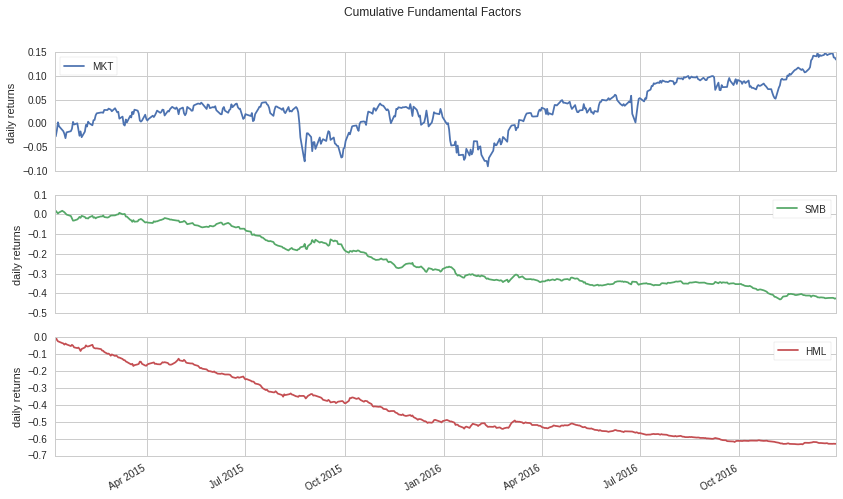

In [35]:
ax = ((F + 1).cumprod() - 1).plot(subplots=True, title='Cumulative Fundamental Factors')
ax[0].set(ylabel = "daily returns")
ax[1].set(ylabel = "daily returns")
ax[2].set(ylabel = "daily returns")
plt.show()

In [36]:
assets = tickers
R = rets0 

In [37]:
# factor exposure
B = pd.DataFrame(index=assets, dtype=np.float32)
epsilon = pd.DataFrame(index=R.index, dtype=np.float32)

In [38]:
x = sm.add_constant(F)

for i in assets:
    y = R.loc[:,i]
    y_inlier = y[np.abs(y - y.mean())<=(3*y.std())]
    x_inlier = x[np.abs(y - y.mean())<=(3*y.std())]
    result = sm.OLS(y_inlier, x_inlier).fit()

    B.loc[i,"MKT_beta"] = result.params[1]
    B.loc[i,"SMB_beta"] = result.params[2]
    B.loc[i,"HML_beta"] = result.params[3]
    epsilon.loc[:,i] = y - (x.iloc[:,0] * result.params[0] +
                            x.iloc[:,1] * result.params[1] + 
                            x.iloc[:,2] * result.params[2] +
                            x.iloc[:,3] * result.params[3])
 

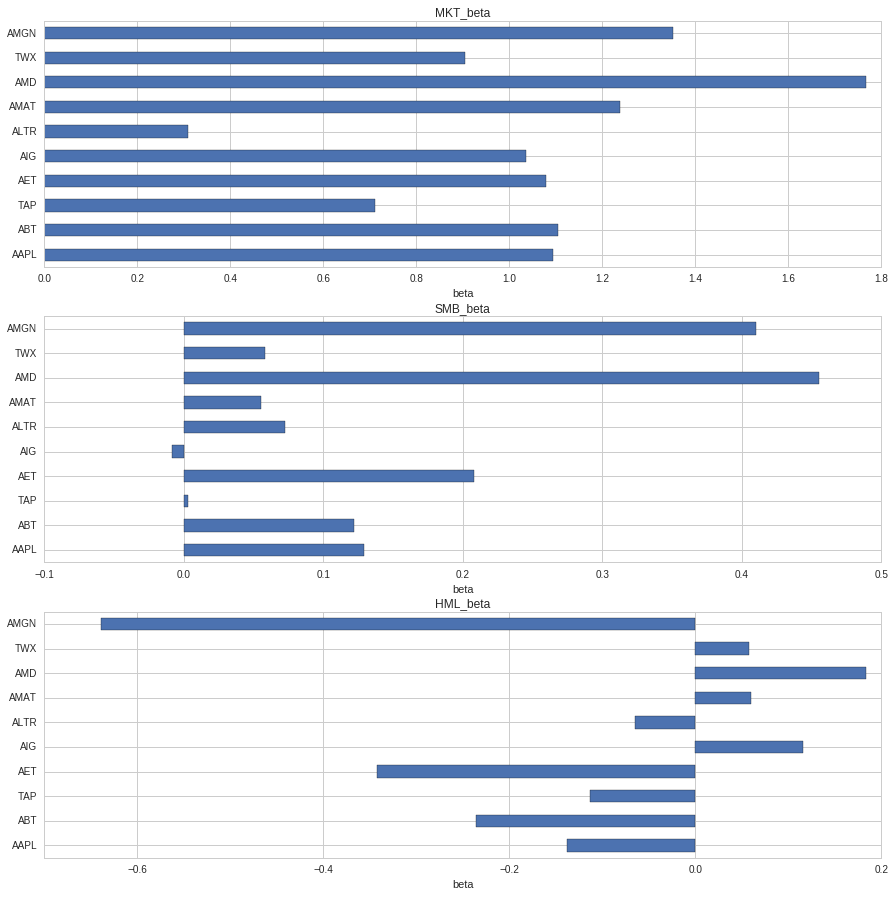

In [39]:
fig,axes = plt.subplots(3, 1)
ax1,ax2,ax3 =axes

B.iloc[0:10,0].plot.barh(ax=ax1, figsize=[15,15], title=B.columns[0])
B.iloc[0:10,1].plot.barh(ax=ax2, figsize=[15,15], title=B.columns[1])
B.iloc[0:10,2].plot.barh(ax=ax3, figsize=[15,15], title=B.columns[2])

ax1.set(xlabel='beta')
ax2.set(xlabel='beta')
ax3.set(xlabel='beta')
plt.show()

In [40]:
w = np.ones([1,R.shape[1]])/R.shape[1]

In [41]:
def compute_common_factor_variance(factors, factor_exposures, w):   
    B = np.asarray(factor_exposures)
    F = np.asarray(factors)
    V = np.asarray(factors.cov())
    
    return w.dot(B.dot(V).dot(B.T)).dot(w.T)

common_factor_variance = compute_common_factor_variance(F, B, w)[0][0]
print("Common Factor Variance: {0}".format(common_factor_variance))

Common Factor Variance: 8.50494486212e-05


In [42]:
def compute_specific_variance(epsilon, w):       
    
    D = np.diag(np.asarray(epsilon.var())) * epsilon.shape[0] / (epsilon.shape[0]-1)

    return w.dot(D).dot(w.T)

specific_variance = compute_specific_variance(epsilon, w)[0][0]
print("Specific Variance: {0}".format(specific_variance))

Specific Variance: 2.69127481893e-06


In [43]:
common_factor_pct = common_factor_variance/(common_factor_variance + specific_variance)*100.0
print("Percentage of Portfolio Variance Due to Common Factor Risk: {0:.2f}%".format(common_factor_pct))

Percentage of Portfolio Variance Due to Common Factor Risk: 96.93%


position-concentration-risk

In [44]:
from scipy import optimize
import cvxopt as opt
import cvxpy 

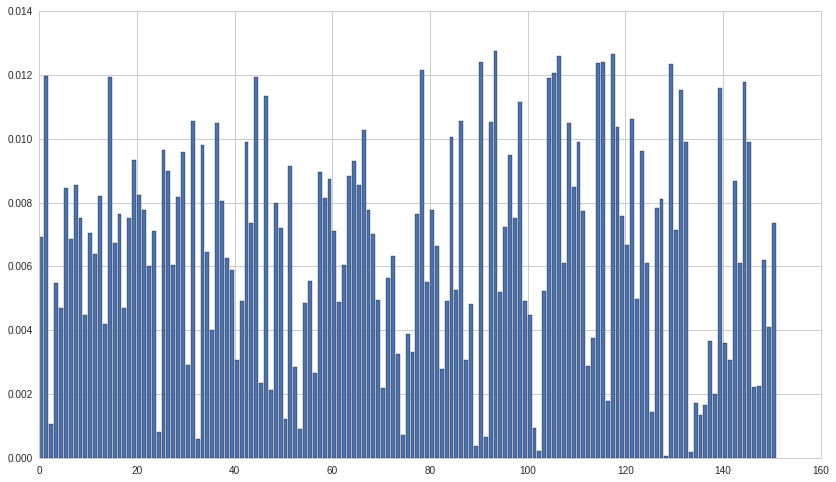

In [45]:
# Random weights
def scale(x):
    return x / np.sum(np.abs(x))

weights_r = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights_r);

In [46]:
# Equal Weights 
eweights_df = len(asset_list) * [float(1)/len(asset_list)]
weights = eweights_df

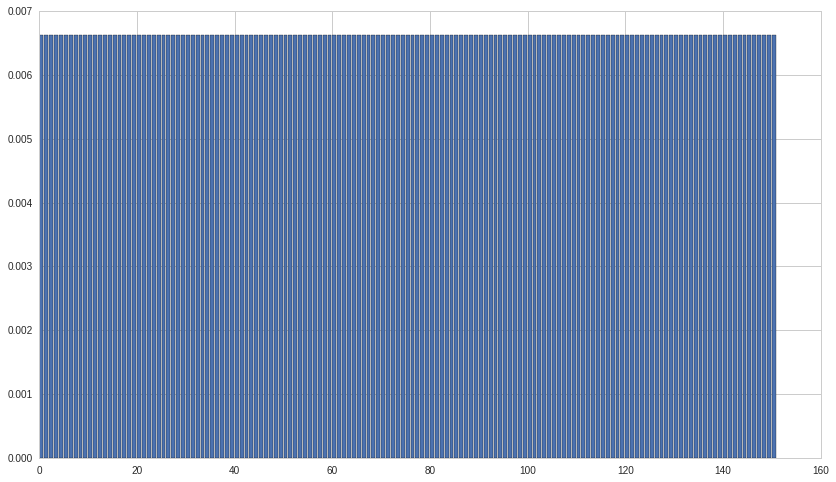

In [47]:
plt.bar(np.arange(num_stocks),weights);

In [48]:
time_start = '2015-01-05'
time_halfway = '2015-06-01'
time_end = '2015-12-31'

In [49]:
def get_markowitz_weights(mu, Sigma, gamma=1, max_position=1.0, max_leverage=1.0, short=True):
    w = cvxpy.Variable(len(Sigma))
    g = cvxpy.Parameter(sign='positive')
    L = cvxpy.Parameter()
    g.value = gamma
    L.value = max_leverage
    try:
        ret = mu.T*w
    except ValueError:
        ret = mu*w
    
    risk = cvxpy.quad_form(w, Sigma)
    
    objective = cvxpy.Maximize(ret - g*risk)
    constraints = [
        cvxpy.abs(w) < max_position,
        cvxpy.norm(w, 1) <= L, # Make it so we don't have to invest everything
    ]
    
    if not short:
        constraints.append(w >= 0) # Force all positive weights
    
    prob = cvxpy.Problem(
        objective,
        constraints
    )
    
    result = prob.solve()
    
    return w.value

In [50]:
mu = rets[tickers].\
        loc[:time_halfway].fillna(0).mean().as_matrix()
sigma = rets[tickers].\
        loc[:time_halfway].fillna(0).cov().as_matrix()

mkweights_df = get_markowitz_weights(mu, sigma)

In [51]:
# markowitz_weights 
weights_mkw = mkweights_df

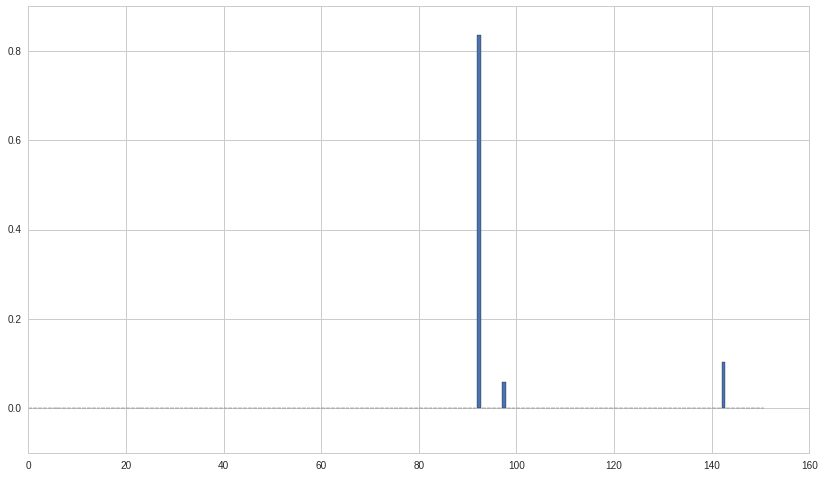

In [52]:
plt.bar(np.arange(num_stocks),weights_mkw);

In [53]:
value_invested = 10000000

In [54]:
def value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    returns = returns.fillna(0.0)
    # Multiply asset returns by weights to get one weighted portfolio return
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [55]:
def cvar(value_invested, returns, weights, alpha=0.95, lookback_days=600):
    # Call out to our existing function
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    # Get back to a return rather than an absolute loss
    var_pct_loss = var / value_invested
    
    return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])

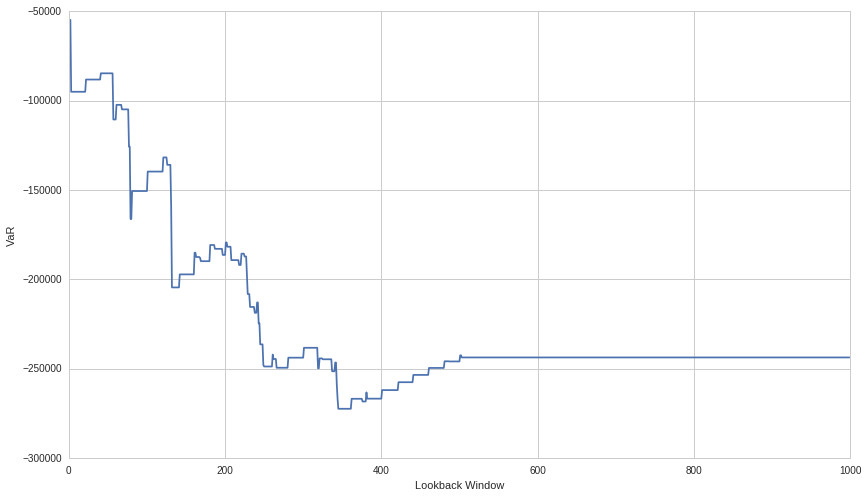

In [57]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = cvar(value_invested, returns, weights, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

In [58]:
cvar(value_invested, returns, weights_mkw, lookback_days=600)

-173838.61696162442

In [59]:
cvar(value_invested, returns, weights, lookback_days=600)

-243797.13582178939

In [60]:
cvar(value_invested, returns, weights_r, lookback_days=600)

-248255.15796972919

mean    1.879571e-19
std     9.992138e-03
25%    -4.876215e-03
50%     1.497118e-04
75%     5.954801e-03
min    -4.051857e-02
max     3.669276e-02
dtype: float64


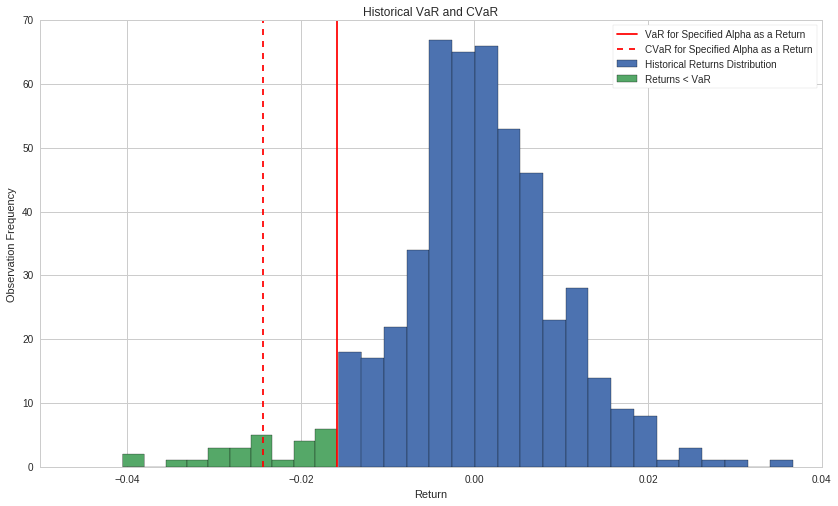

In [61]:
lookback_days = 600
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_CVaR_return = portfolio_CVaR / value_invested

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');
print(portfolio_returns.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

mean   -0.180191
std     0.625790
min    -2.595295
max     1.741747
dtype: float64


/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


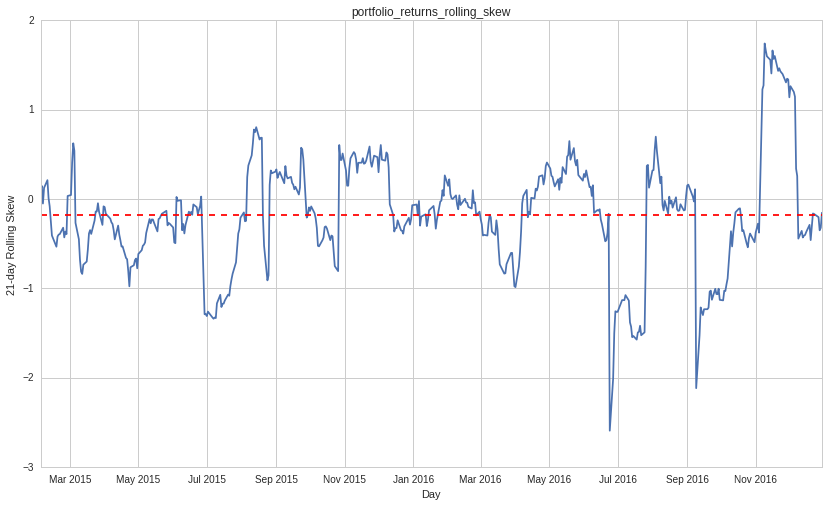

In [62]:
rolling_skew = portfolio_returns.rolling(window=21,center=False).skew()
plt.plot(rolling_skew)
plt.axhline(rolling_skew.mean(), color='red', linestyle='--')
plt.xlabel('Day')
plt.ylabel('21-day Rolling Skew')
plt.title('portfolio_returns_rolling_skew')
print(rolling_skew.describe().loc[['mean', 'std', 'min', 'max']]);

mean    1.879571e-19
std     9.992138e-03
25%    -4.876215e-03
50%     1.497118e-04
75%     5.954801e-03
min    -4.051857e-02
max     3.669276e-02
dtype: float64


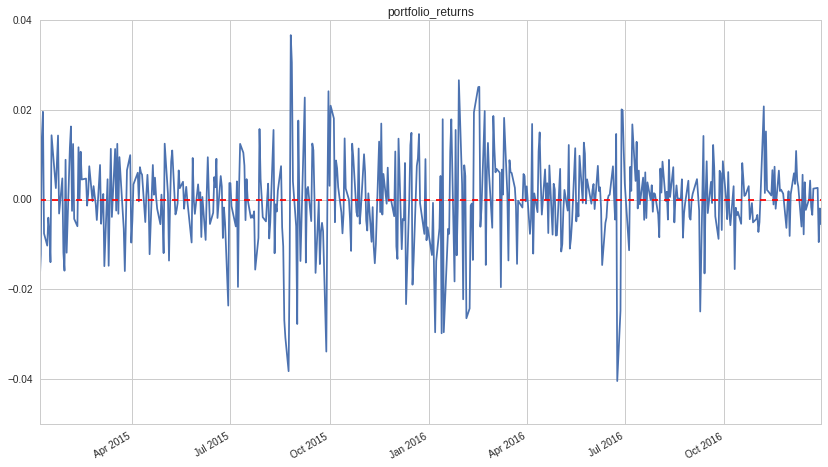

In [63]:
portfolio_returns.plot();
plt.axhline(portfolio_returns.mean(), color='red', linestyle='--')
plt.title('portfolio_returns')
print(portfolio_returns.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

In [64]:
from statsmodels.stats.stattools import jarque_bera

_, pvalue, _, _ = jarque_bera(portfolio_returns)

if pvalue > 0.05:
    print 'The portfolio returns are likely normal.'
else:
    print 'The portfolio returns are likely not normal.'

The portfolio returns are likely not normal.


In [65]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(portfolio_returns)
pvalue = results[1]

if pvalue < 0.05:
    print 'Process is likely stationary.'
else:
    print 'Process is likely non-stationary.'

Process is likely stationary.


instability-of-estimates

In [66]:
portfolio_returns_mean = portfolio_returns.rolling(window=21).mean()
portfolio_returns_std = portfolio_returns.rolling(window=21).std()

mean    0.000055
std     0.001985
min    -0.006598
max     0.006744
dtype: float64


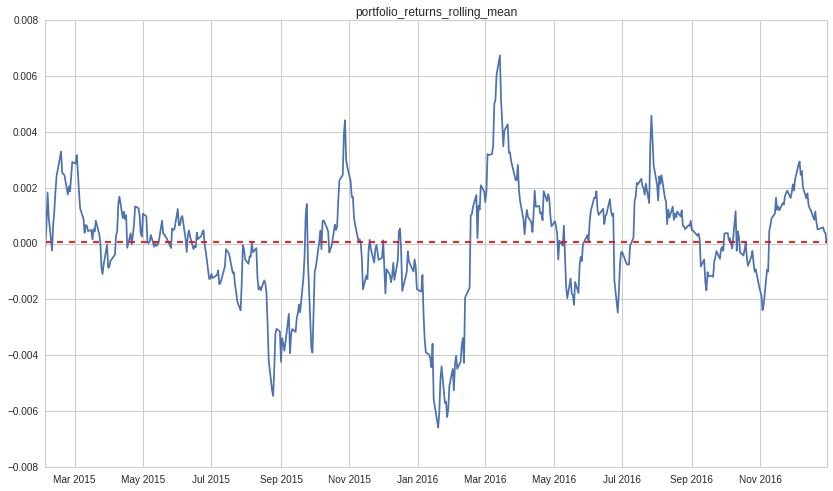

In [67]:
plt.plot(portfolio_returns_mean);
plt.axhline(portfolio_returns_mean.mean(), color='red', linestyle='--')
plt.title('portfolio_returns_rolling_mean')
print(portfolio_returns_mean.describe().loc[['mean', 'std', 'min', 'max']])

mean    0.009315
std     0.003769
min     0.004280
max     0.020105
dtype: float64


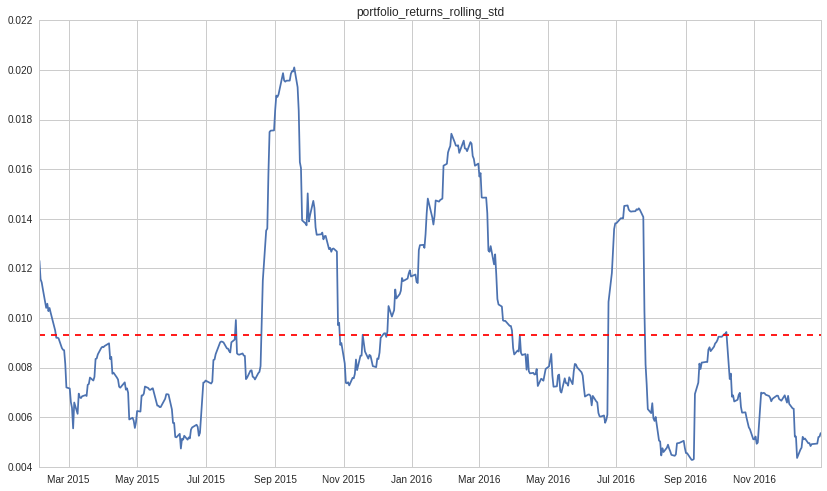

In [68]:
plt.plot(portfolio_returns_std);
plt.axhline(portfolio_returns_std.mean(), color='red', linestyle='--')
plt.title('portfolio_returns_rolling_std')
print(portfolio_returns_std.describe().loc[['mean', 'std', 'min', 'max']])

CAPM & Arbitrage

In [69]:
start_date = '2015-01-01'
end_date = '2017-01-01'

# We will look at the returns of an asset one-month into the future to model future returns.
offset_start_date = '2015-02-02'
offset_end_date = '2017-02-02'

# Get returns data for our assets
asset1 = portfolio_returns
# Get returns for the market
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

In [70]:
# Define a constant to compute intercept
constant = pd.Series(np.ones(len(asset1.index)), index=asset1.index)


df = pd.DataFrame({'portfolio': asset1,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

In [71]:
x = df
r_a = df['portfolio']
r_b = df['SPY']

In [72]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: -0.000310173352401
beta: 1.06262830754


In [73]:
OLS_model = regression.linear_model.OLS(df['portfolio'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()
R1_params = fitted_model.params

In [74]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              portfolio   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     2898.
Date:                Tue, 16 Apr 2019   Prob (F-statistic):          9.19e-276
Time:                        20:45:39   Log-Likelihood:                 2240.7
No. Observations:                 503   AIC:                            -4475.
Df Residuals:                     500   BIC:                            -4463.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SPY            1.0622      0.014     76.065      0.000         1.035     1.090
RF            -1.0637      0.975     -1.091      0.276        -2.978     0.851
Constant      -0.0003      0.000     -2.467      0.014        -0.001 -6.32e-05
==============================================================================
Omnibus:                       13.674   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.626
Skew:                          -0.252   Prob(JB):                     9.02e-05
Kurtosis:                       3.797   Cond. No.                     7.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

           SPY        RF  intercept
mean  1.067581 -0.940359  -0.000358
std   0.059114  2.686988   0.000375
25%   1.017552 -3.228030  -0.000637
50%   1.068020 -1.041231  -0.000317
75%   1.118038  1.291044  -0.000046
min   0.965009 -5.926561  -0.001199
max   1.171443  4.814066   0.000280


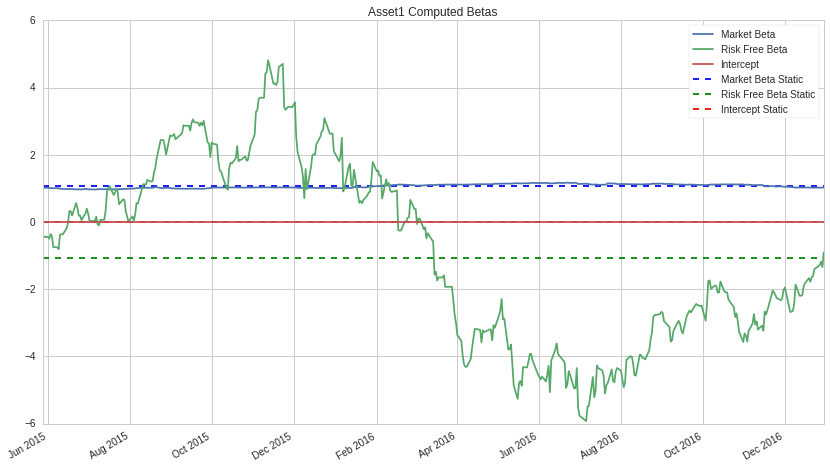

In [76]:
model = pd.stats.ols.MovingOLS(y = df['portfolio'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();

plt.hlines(R1_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')
plt.hlines(R1_params['RF'], df.index[0], df.index[-1], linestyles='dashed', colors='green')
plt.hlines(R1_params['Constant'], df.index[0], df.index[-1], linestyles='dashed', colors='red')

plt.title('Asset1 Computed Betas');
plt.legend(['Market Beta', 'Risk Free Beta', 'Intercept', 'Market Beta Static', 'Risk Free Beta Static', 'Intercept Static']);
print(rolling_parameter_estimates.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

mean    1.067581
std     0.059114
25%     1.017552
50%     1.068020
75%     1.118038
min     0.965009
max     1.171443
Name: SPY, dtype: float64


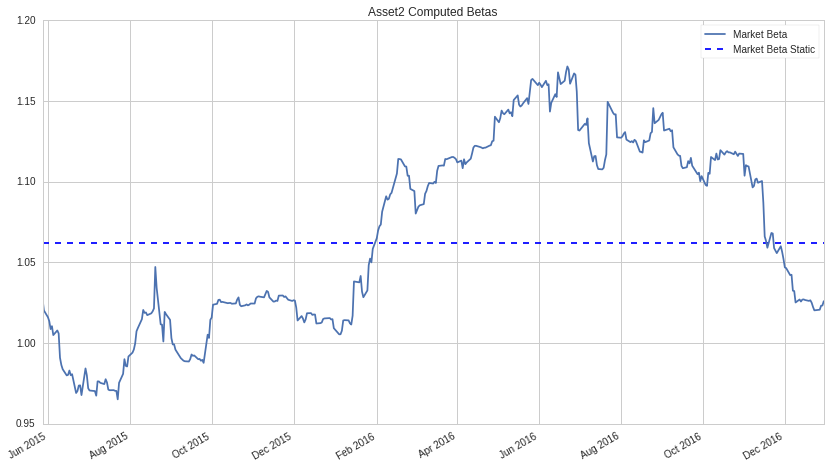

In [77]:
model = pd.stats.ols.MovingOLS(y = df['portfolio'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates['SPY'].plot();

plt.hlines(R1_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')

plt.title('Asset2 Computed Betas');
plt.legend(['Market Beta', 'Market Beta Static']);
print(rolling_parameter_estimates['SPY'].describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

beta-hedging

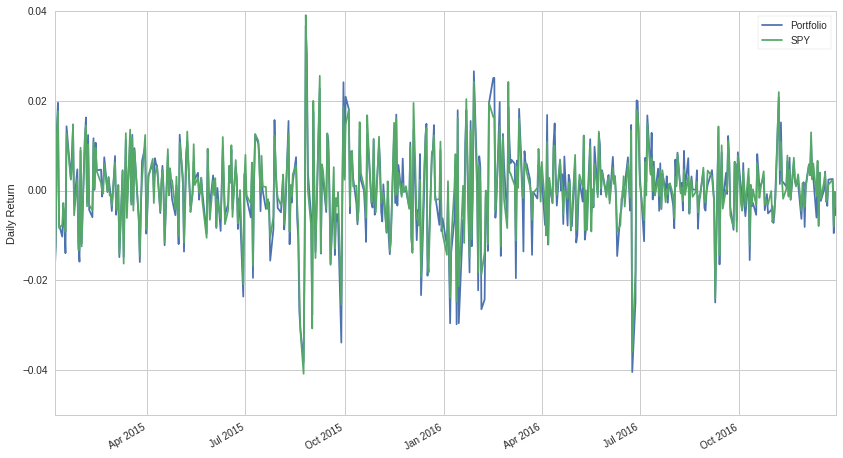

In [78]:
# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = df['portfolio']
r_b = df['SPY']

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend(['Portfolio', 'SPY']);

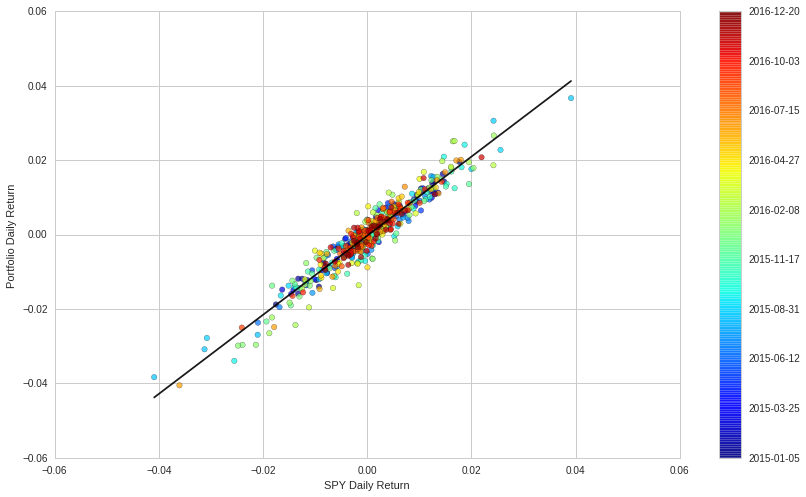

In [79]:
# Plot data and use colormap to indicate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(X))
sc = plt.scatter(X, Y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
    
 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'black', alpha=0.9);

plt.xlabel('SPY Daily Return')
plt.ylabel('Portfolio Daily Return');

In [80]:
from pykalman import KalmanFilter
from scipy import poly1d

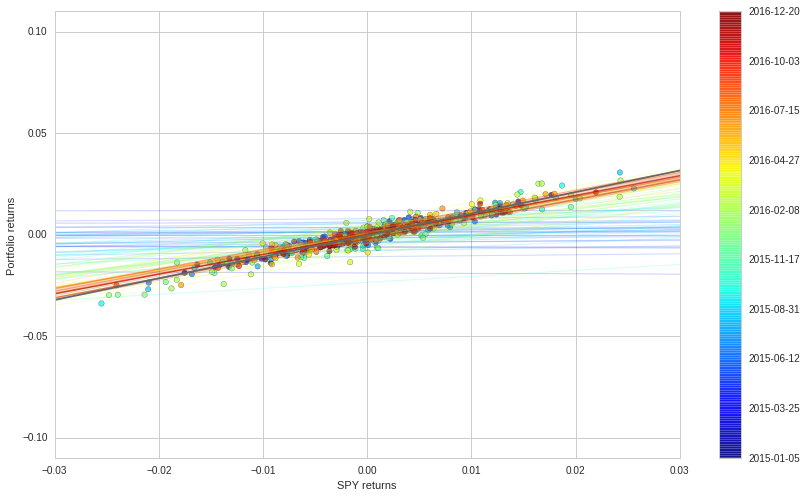

In [81]:
# Get returns from pricing data
x_r = r_b
y_r = r_a

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)
state_means_r, _ = kf_r.filter(y_r.values)

# Plot data points using colormap
colors_r = np.linspace(0.1, 1, len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=colors_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l = np.linspace(0.1, 1, len(state_means_r[::step]))
for i, beta in enumerate(state_means_r[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([-0.03,0.03,-0.11, 0.11])

# Label axes
plt.xlabel('SPY returns')
plt.ylabel('Portfolio returns');

In [82]:
r_a = df['portfolio']
r_b = df['SPY']
alpha, beta = linreg(X,Y)

mean   -0.000310
std     0.002819
25%    -0.001944
50%    -0.000154
75%     0.001454
min    -0.011874
max     0.007899
Name: Portfolio + Hedge, dtype: float64


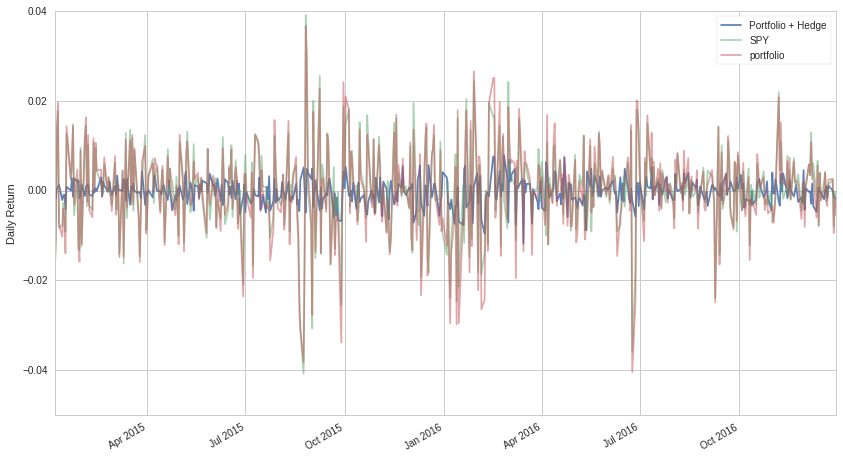

In [83]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a
portfolio.name = "Portfolio + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();
print(portfolio.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']]);

In [84]:
P = portfolio.values
alpha, beta = linreg(X,P)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: -0.000310173352401
beta: 5.86661795532e-16


In [85]:
 rolling_corr = portfolio.rolling(window=21).corr(r_b) 

mean   -0.041895
std     0.292733
min    -0.665652
max     0.599183
dtype: float64


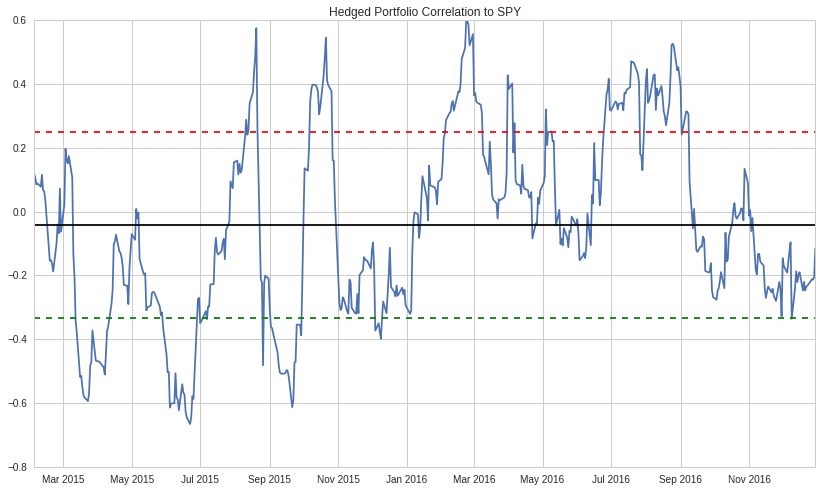

In [86]:
corr_mean = rolling_corr.mean()
corr_std = rolling_corr.std()

plt.plot(rolling_corr)

plt.axhline(rolling_corr.mean(), color='black')
plt.axhline(corr_mean + corr_std, linestyle='--', color='red')
plt.axhline(corr_mean - corr_std, linestyle='--', color='green')

plt.title('Hedged Portfolio Correlation to SPY')

print(rolling_corr.describe().loc[['mean', 'std', 'min', 'max']]);

In [87]:
df = pd.DataFrame({'hedged_portfolio': portfolio,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

mean    0.004953
std     0.059114
25%    -0.045076
50%     0.005392
75%     0.055410
min    -0.097619
max     0.108814
Name: SPY, dtype: float64


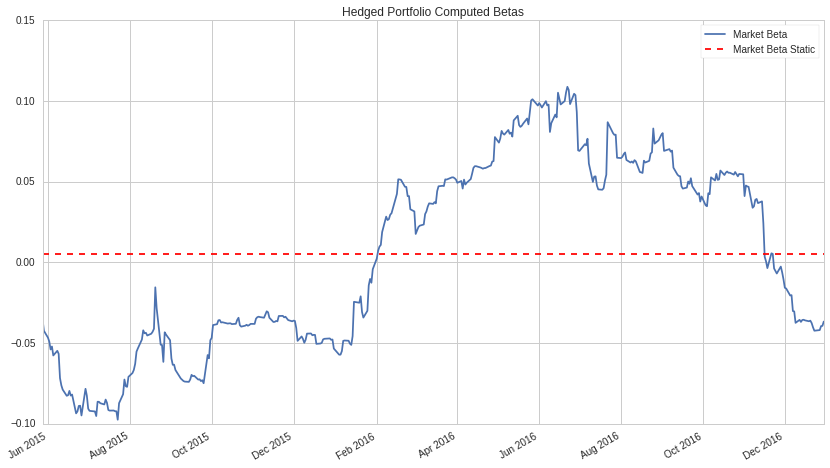

In [88]:
model = pd.stats.ols.MovingOLS(y = df['hedged_portfolio'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates['SPY'].plot();
plt.axhline(rolling_parameter_estimates['SPY'].mean(), color='red', linestyle='--')
plt.title('Hedged Portfolio Computed Betas');
plt.legend(['Market Beta', 'Market Beta Static']);
print(rolling_parameter_estimates['SPY'].describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

In [89]:
state_means, state_covs = kf_r.filter(portfolio.values)

Kalman Estimated Beta Mean: -0.0120709306428
Kalman Estimated Beta Std: 0.0202035198149


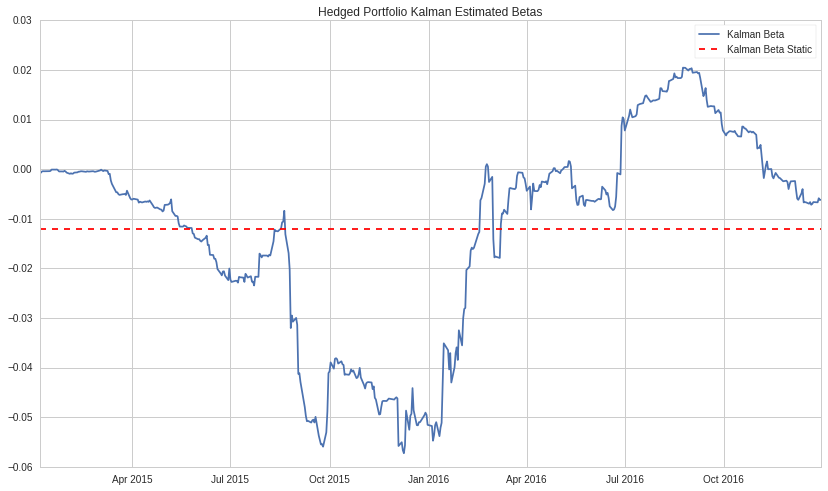

In [90]:
plt.plot(x.index, state_means[:,0])
plt.axhline(state_means[:,0].mean(), color='red', linestyle='--')
plt.title('Hedged Portfolio Kalman Estimated Betas')
plt.legend(['Kalman Beta', 'Kalman Beta Static'])
kalman_beta = state_means[:,0].mean()
kalman_std = state_means[:,0].std()
print("Kalman Estimated Beta Mean: {0}".format(kalman_beta))
print("Kalman Estimated Beta Std: {0}".format(kalman_std));

Kalman Estimated Intercept Mean: -0.000311356135692


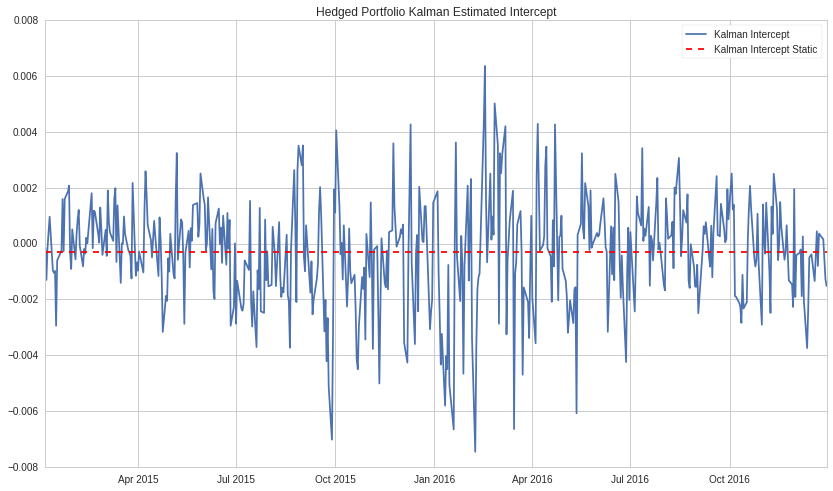

In [91]:
plt.plot(x.index, state_means[:,1])
plt.axhline(state_means[:,1].mean(), color='red', linestyle='--')
plt.title('Hedged Portfolio Kalman Estimated Intercept')
plt.legend(['Kalman Intercept', 'Kalman Intercept Static'])
kalman_beta = state_means[:,1].mean()
print("Kalman Estimated Intercept Mean: {0}".format(kalman_beta));

mean    1.879571e-19
std     9.992138e-03
25%    -4.876215e-03
50%     1.497118e-04
75%     5.954801e-03
min    -4.051857e-02
max     3.669276e-02
dtype: float64


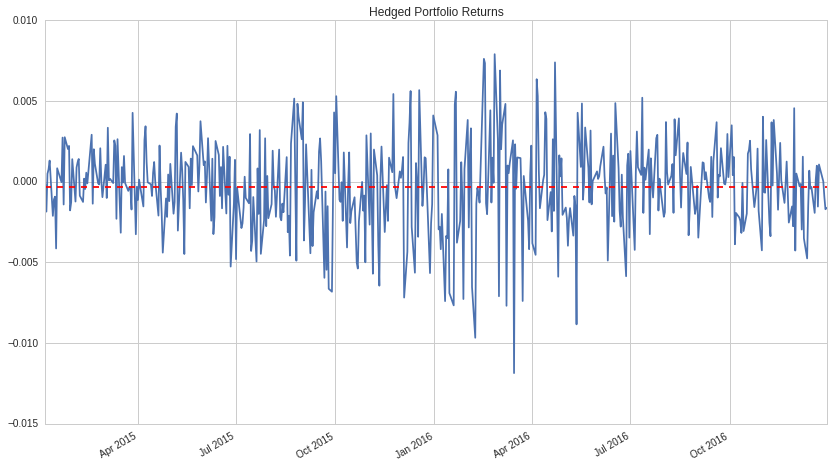

In [92]:
portfolio.plot();
plt.axhline(portfolio.mean(), color='red', linestyle='--')
plt.title('Hedged Portfolio Returns')
print(portfolio_returns.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

In [93]:
_, pvalue, _, _ = jarque_bera(portfolio)

if pvalue > 0.05:
    print 'The portfolio returns are likely normal.'
else:
    print 'The portfolio returns are likely not normal.'

The portfolio returns are likely not normal.


In [94]:
results = adfuller(portfolio)
pvalue = results[1]

if pvalue < 0.05:
    print 'Process is likely stationary.'
else:
    print 'Process is likely non-stationary.'

Process is likely stationary.


In [95]:
hedged_pf_means = portfolio.rolling(window=21).mean()
hedged_pf_std = portfolio.rolling(window=21).std()

mean    1.879571e-19
std     9.992138e-03
25%    -4.876215e-03
50%     1.497118e-04
75%     5.954801e-03
min    -4.051857e-02
max     3.669276e-02
dtype: float64


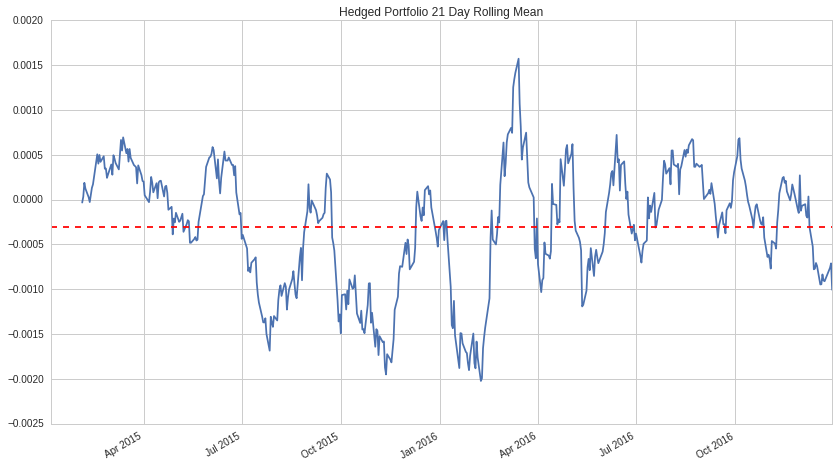

In [96]:
hedged_pf_means.plot();
plt.axhline(hedged_pf_means.mean(), color='red', linestyle='--')
plt.title('Hedged Portfolio 21 Day Rolling Mean')
print(portfolio_returns.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

mean    1.879571e-19
std     9.992138e-03
25%    -4.876215e-03
50%     1.497118e-04
75%     5.954801e-03
min    -4.051857e-02
max     3.669276e-02
dtype: float64


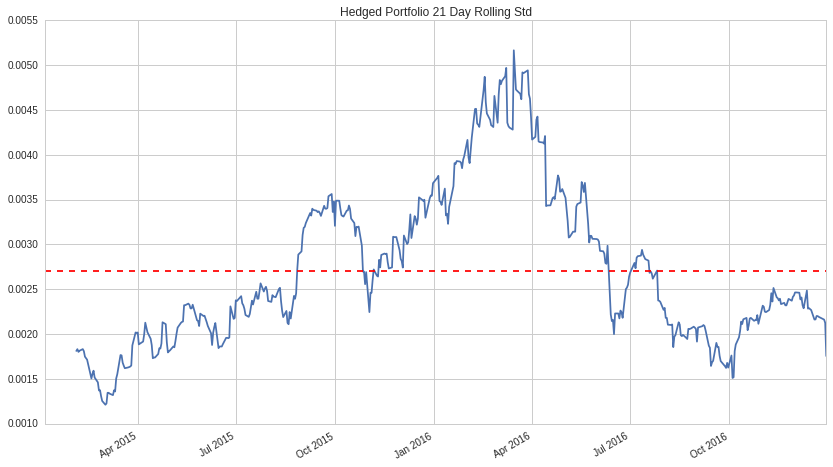

In [97]:
hedged_pf_std.plot();
plt.axhline(hedged_pf_std.mean(), color='red', linestyle='--')
plt.title('Hedged Portfolio 21 Day Rolling Std')
print(portfolio_returns.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

instability-of-estimates

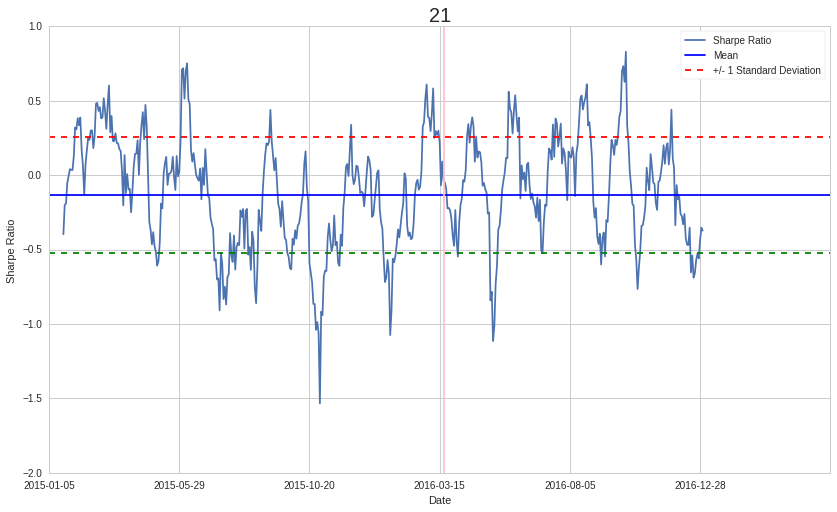

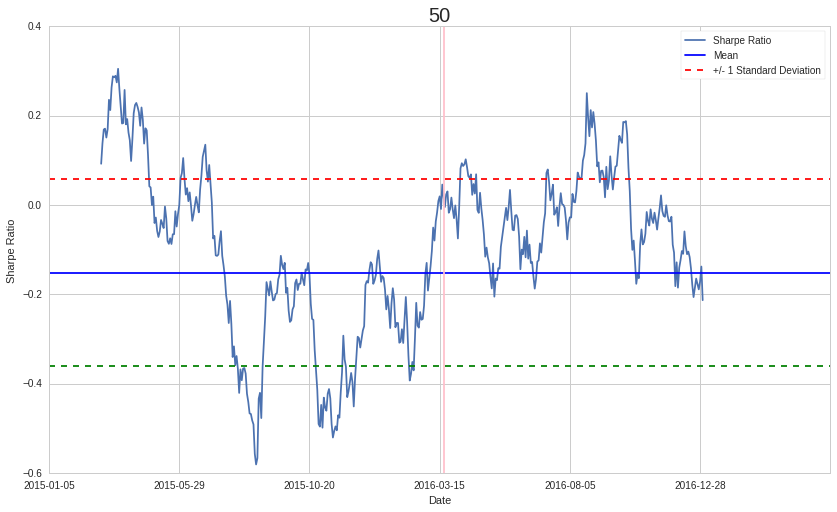

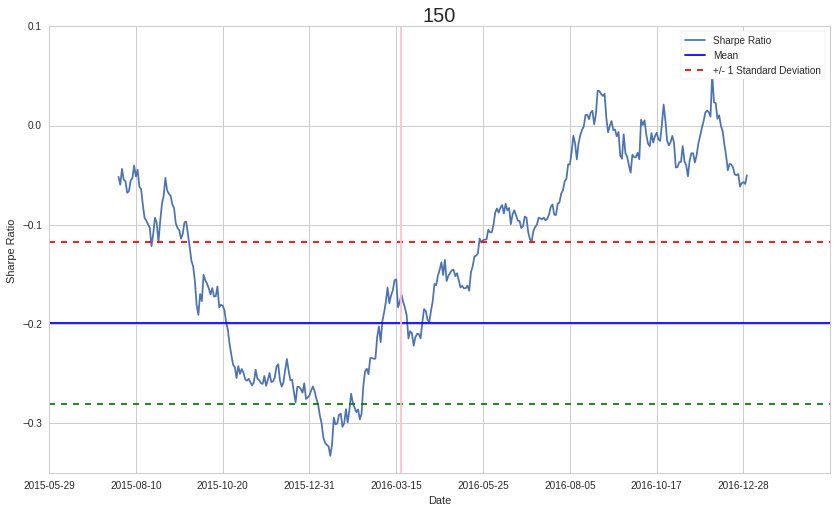

In [100]:
def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

for window in [21, 50, 150]:
    running_sharpe = [sharpe_ratio(portfolio[i-window+10:i], treasury_ret[i-window+10:i]) for i in range(window-10, len(portfolio))]
    mean_rs = np.mean(running_sharpe[:-200])
    std_rs = np.std(running_sharpe[:-200])
    
    _, ax2 = plt.subplots()
    
    ax2.plot(range(window-10, len(portfolio)), running_sharpe)
    ticks = ax2.get_xticks()

    ax2.set_xticklabels([portfolio.index[i].date() for i in ticks[:-1]])
    
    ax2.axhline(mean_rs)
    ax2.axhline(mean_rs + std_rs, linestyle='--', color='red')
    ax2.axhline(mean_rs - std_rs, linestyle='--', color='green')
    
    ax2.axvline(len(returns) - 200, color='pink');
    plt.title(window, fontsize = 20)
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

risk-constrained-portfolio-optimization